# CMIP6 data

This notebook shows how to access CMIP6 data from the cloud

## Import modules and libraries

*First, let's make sure the Python env is correct to run this notebook*:

In [1]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2025/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"), 
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    ds2tools = check_up_env(with_tuto=True)

/tmp/tmp_mw1d6c4/utils.py:65: UserWarning: 
Running on your own environment
Make sure to have all necessary packages installed
See:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml
  warnings.warn("\nRunning on your own environment\nMake sure to have all necessary packages installed\nSee:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml")


<module 'tuto_tools' from '/scratch/synced/environment/tuto_tools.py'>


In [2]:
import sys
import gcsfs
import xarray as xr
import intake
import zarr
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
create_map = ds2tools.create_map

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# 
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Read the full CMIP6 catalog

In [3]:
df_full = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_full.sample(10)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
482696,PAMIP,NCAR,CESM1-WACCM-SC,pa-pdSIC,r91i1p1f1,Amon,sfcWind,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pa-...,NaN,20201012
324051,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r16i1p1f1,Amon,tasmax,gn,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,2005.0,20191007
420729,CMIP,NCAR,CESM2-WACCM-FV2,historical,r2i1p1f1,Omon,pp,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/his...,NaN,20200226
364343,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r23i1p1f1,Omon,fgco2,gr,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1978.0,20191016
364397,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r24i1p1f1,Omon,sos,gn,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1978.0,20191016
461232,CMIP,NCC,NorCPM1,historical,r12i1p1f1,Amon,va,gn,gs://cmip6/CMIP6/CMIP/NCC/NorCPM1/historical/r...,NaN,20200724
313158,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r5i1p1f1,Amon,rsus,gn,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1996.0,20191007
205790,CMIP,MRI,MRI-ESM2-0,piControl,r1i1p1f1,Lmon,mrro,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/piControl...,NaN,20190603
463097,CMIP,CSIRO,ACCESS-ESM1-5,esm-hist,r7i1p1f1,Omon,chl,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/esm-...,NaN,20200730
342525,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r32i1p1f1,Amon,rsdt,gn,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1961.0,20191007


### Make a subset of it

In [7]:
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS' & experiment_id == 'historical'")
# df = df_full.query('institution_id == "CNRM-CERFACS" & member_id=="r1i1p1f2" & source_id=="CNRM-CM6-1"')

# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'abrupt-4xCO2'")

# df = df.query("source_id=='CNRM-CM6-1-HR' & variable_id=='thetao'") # Horizontal resolution up to 1/4 deg
# df = df.query("source_id=='CNRM-ESM2-1' & variable_id=='thetao'") # Horizontal resolution up to 1deg
df = df.query("source_id=='CNRM-ESM2-1' & (variable_id=='thetao' | variable_id=='so')") # Horizontal resolution up to 1deg

# df = df.sort_values('version')
df = df.sort_values('member_id')
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
406634,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r10i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200117
406642,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r10i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200117
430447,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r11i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200408
44083,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
44013,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
51505,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r2i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51514,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r2i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51428,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r3i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
50556,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r3i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51214,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r4i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125


## Read some data (1 row of the catalog)

In [8]:
def open_cmip6(df_row):
    # get the path to zarr store
    zstore = df.zstore.values[-1]
    print(zstore)
    
    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(zstore)

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    print("Size of this dataset:", ds.nbytes/1e9,"Gb")

    return ds

ds = open_cmip6(df.iloc[0])
ds

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb


<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, lev: 75, axis_nbounds: 2,
                  time: 1980)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds   (lev, axis_nbounds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(4, 75, 294, 362), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_historical_r9i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/8e969929-c070-414d-9eca-f4c99b7be8b7...
    variable_id:            thetao
    variant_label:          r9i1p1f2
    xios_commit:            1442-shuffle
    netcdf_tracking_ids:    hdl:21.14100/8e969929-c070-414d-9eca-f4c99b7be8b7...
    version_id:             v20200117

### Play with it

In [ ]:
# Compute size of the full df selection:
total_size = 0 # Gb
for index, row in df.iterrows():
    ds = open_cmip6(row)
    total_size += ds.nbytes/1e9
print("Size of the selection of datasets:", total_size, "Gb")    

In [ ]:
sst = ds['thetao'].sel(lev=0, method='nearest')
sst

In [ ]:
sst.sel(time='1978-05-28T12:00:00', method='nearest').plot()

In [ ]:
sst.where(sst['lat']>=0).where(sst['lon']>=360-275).sel(time='1978-05-28T12:00:00', method='nearest').plot(xlim=[0, 120], ylim=[140, 270])

### Horizontal resolution of the grid

In [ ]:
ds['lat'].isel(x=0).diff('y').plot()

In [ ]:
ds['lon'].isel(y=0).diff('x').plot()

## Connect to a cluster for large computation

In [32]:
import coiled
from dask.distributed import Client
# Connect to one of the existing class cluster: 
# cluster = coiled.Cluster(name="ds2-highmem-binder", workspace="class-2025")
cluster = coiled.Cluster(name="ds2-highcpu-binder", workspace="class-2025")
client = cluster.get_client()

Output()

## Compute climatology

In [29]:
ds = open_cmip6(df.iloc[0])
print("Size of this dataset:", ds.nbytes/1e9,"Gb")

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/historical/r1i1p1f2/Omon/thetao/gn/v20191021/
Size of this dataset: 899.43601332 Gb
Size of this dataset: 899.43601332 Gb


In [33]:
%%time
t = ds['thetao'].sel(lev=700, method='nearest')
# t = t.where(t['lat']>=30).where(t['lon']>=360-275)
# t = t.where(t['time']>=pd.to_datetime('2100-01-01'))
# t
tm = t.mean(dim='time')
tm

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.4 ms


<xarray.DataArray 'thetao' (y: 1050, x: 1442)>
dask.array<mean_agg-aggregate, shape=(1050, 1442), dtype=float32, chunksize=(1050, 1442), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lev      float64 697.3
    lon      (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
Dimensions without coordinates: y, x

In [ ]:
%%time
tm = tm.compute().persist()
tm

Text(0.5, 1.0, 'Ocean temperature climatology at z=697.3 m')

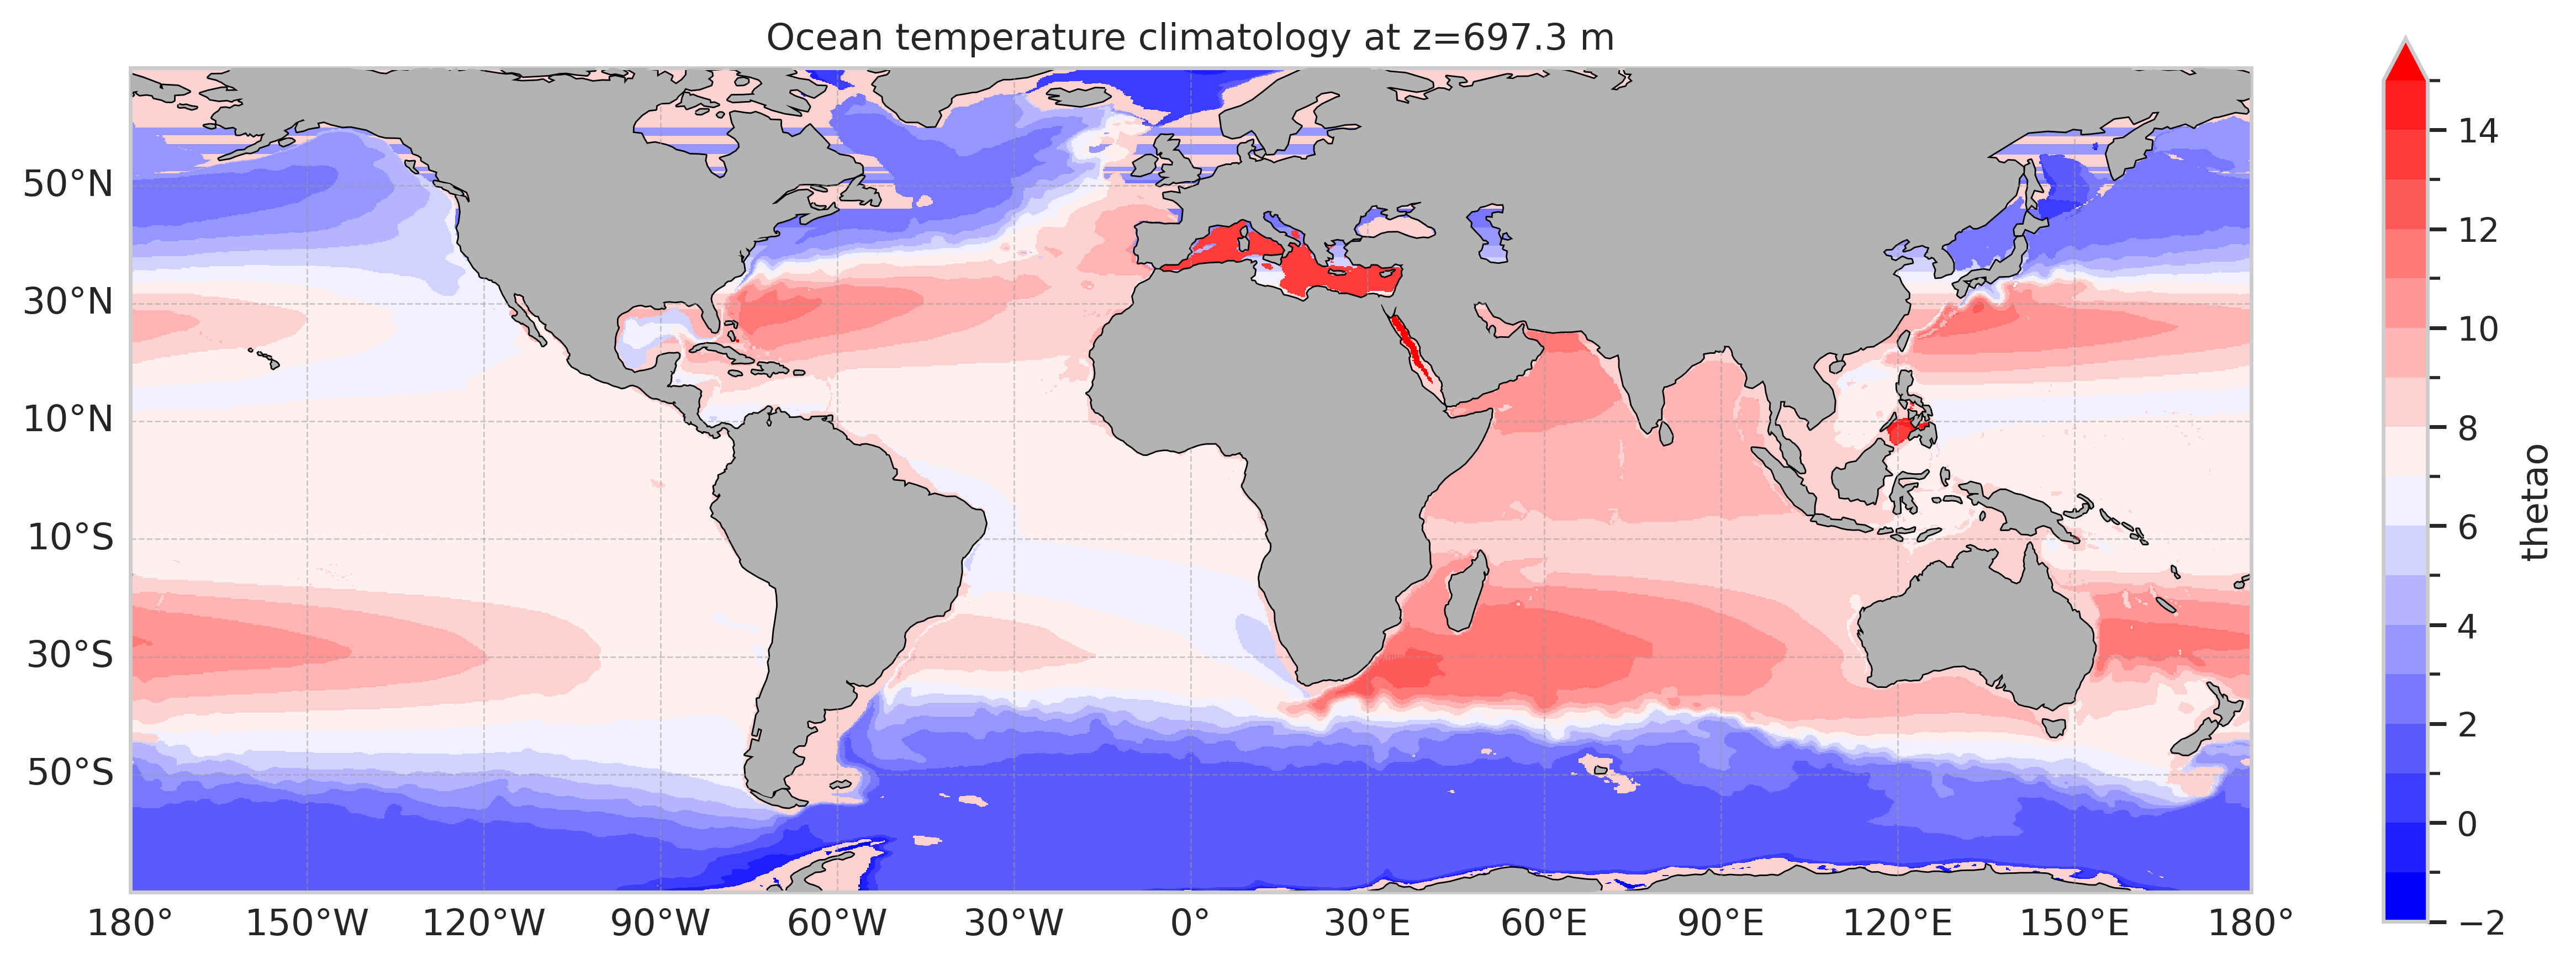

In [27]:
fig, proj, ax = create_map()
tm.plot(transform=proj, x='lon', y='lat', ax=ax, 
        vmin=-2, vmax=15, levels=18, 
        cmap=mpl.colormaps.get_cmap('bwr'))
# ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.LAND, facecolor=[0.7]*3, zorder=100)
ax.set_title("Ocean temperature climatology at z=%0.1f m" % tm['lev'].data)

## Checkout a High resolution simulation

In [16]:
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS' & experiment_id == 'historical'")
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS' & experiment_id == 'piControl'")
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS'")
# df = df_full.query('institution_id == "CNRM-CERFACS" & member_id=="r1i1p1f2" & source_id=="CNRM-CM6-1"')

# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'abrupt-4xCO2'")

# df = df.query("source_id=='CNRM-CM6-1-HR'") # Horizontal resolution up to 1/4 deg
df = df.query("source_id=='CNRM-CM6-1-HR' & variable_id=='thetao'") # Horizontal resolution up to 1/4 deg
# df = df.query("source_id=='CNRM-ESM2-1' & variable_id=='thetao'") # Horizontal resolution up to 1deg
# df = df.query("source_id=='CNRM-ESM2-1' & (variable_id=='thetao' | variable_id=='so')") # Horizontal resolution up to 1deg

# df = df.sort_values('version')
df = df.sort_values('member_id')
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
375709,CMIP,CNRM-CERFACS,CNRM-CM6-1-HR,historical,r1i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-...,NaN,20191021


In [18]:
this_df = df[df['variable_id'] == 'thetao'].iloc[0]
# this_df = df[df['experiment_id'] == 'piControl'].iloc[0]
ds = open_cmip6(this_df)
ds

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/historical/r1i1p1f2/Omon/thetao/gn/v20191021/
Size of this dataset: 899.43601332 Gb


<xarray.Dataset>
Dimensions:      (y: 1050, x: 1442, nvertex: 4, lev: 75, axis_nbounds: 2,
                  time: 1980)
Coordinates:
    bounds_lat   (y, x, nvertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    lat          (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds   (lev, axis_nbounds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(1, 75, 1050, 1442), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-CM6-1-HR_historical_r1i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.3
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/5ca16c26-62bf-4e74-b29b-8f8fb03ef7ad...
    variable_id:            thetao
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    netcdf_tracking_ids:    hdl:21.14100/5ca16c26-62bf-4e74-b29b-8f8fb03ef7ad...
    version_id:             v20191021

In [19]:
%%time
t = ds['thetao'].sel(lev=700, method='nearest')
tm = t.mean(dim='time')
tm = tm.compute().persist()
tm

CPU times: user 1.05 s, sys: 54.6 ms, total: 1.1 s
Wall time: 4min 49s


<xarray.DataArray 'thetao' (y: 1050, x: 1442)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lat      (y, x) float32 -78.54 -78.54 -78.54 -78.54 ... 50.02 50.0 50.0
    lev      float64 697.3
    lon      (y, x) float32 72.75 73.0 73.25 73.5 ... 73.01 73.01 73.0 73.0
Dimensions without coordinates: y, x

Text(0.5, 1.0, 'Ocean temperature climatology at z=697.3 m')

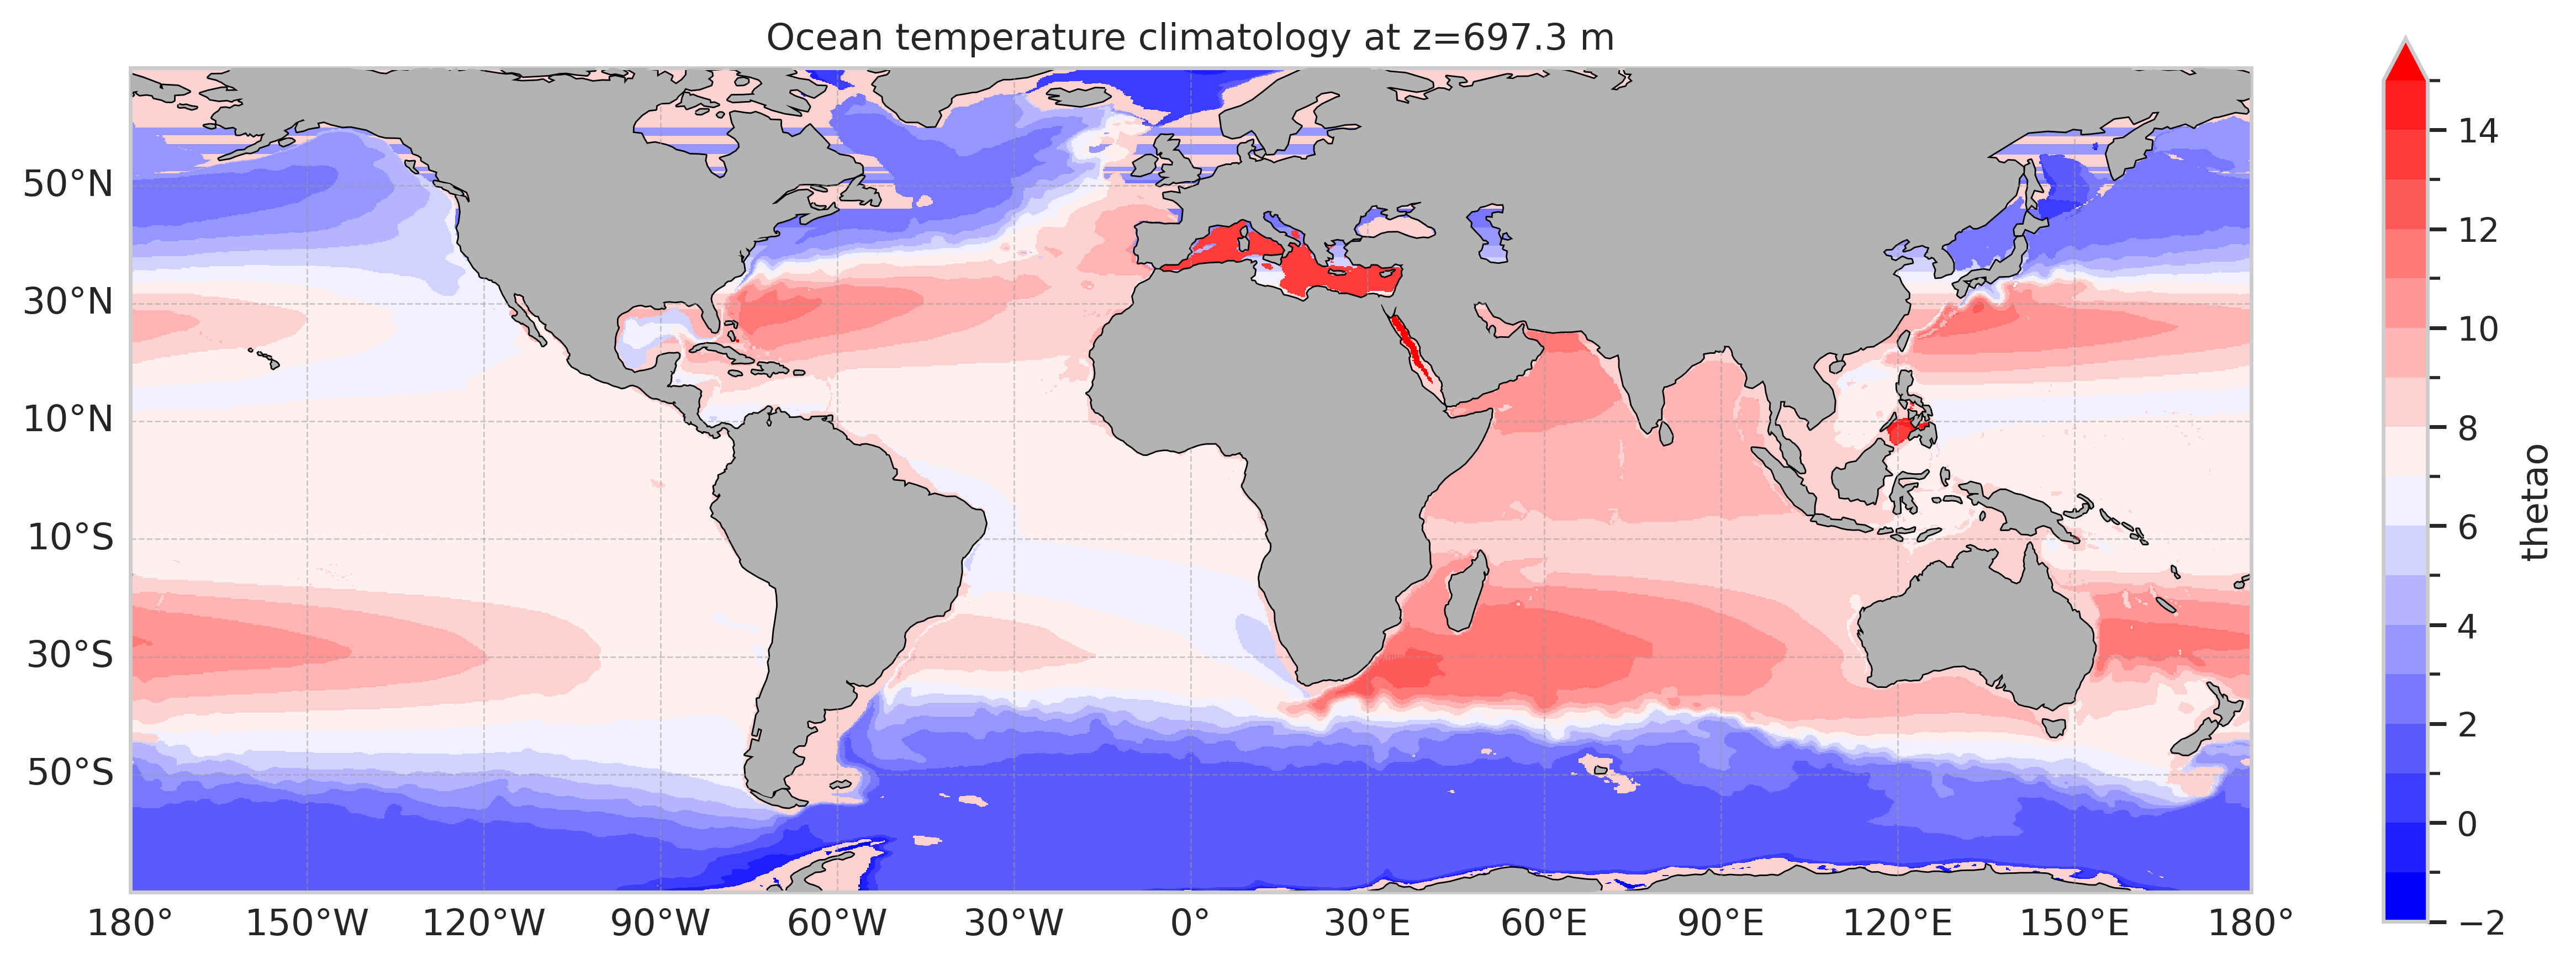

In [22]:
fig, proj, ax = create_map()
# fig, proj, ax = create_map(extent=[-90, 0, 0, 80])
tm.plot(transform=proj, x='lon', y='lat', ax=ax, 
        vmin=-2, vmax=15, levels=18, 
        cmap=mpl.colormaps.get_cmap('bwr'))
# ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.LAND, facecolor=[0.7]*3, zorder=100)
ax.set_title("Ocean temperature climatology at z=%0.1f m" % tm['lev'].data)